## Searching for Hardware Aware Neural Networks on ImageNet for FPGA in MobilenetV3 Search Space

We need to estimate the accuracy of samples in our search space because it requires significant amount of time to train each subnet for evaluating its perfomace. This slows down the searching process. Accuracy peredictory MLP that was trained on the (arch, accu) dataset in our search space is used to speed up the search process as we won't have to train the network at all. The search is perfomed on the Imagenet Dataset. 

We have also build a latency table by manualy deploying all the unique blocks of our search space on ULTRA96v2 FPGA board this will be utilized to estimate latency of our networks.


#### IDEA
Introducing a new parameter by combining the model size(params), mac ops , and latency called efficient_arthemetic_intensity which is defined   

efficient_arthemetic_intensity = macs/(model_size*latency) ops/(byte*ms)  

Trying to do three things maximizing the mac operations perfomed by model which represents the learning capacity
of model while minimizing the number of paramters which is the size of model and also minimizing the latency 
on target hardware thus finding a model that has performs maximum calculation while being smaller and faster.


### Overview
Every architecutre configuration is represented in dictionary format.  
Accuracy predictor predicts accuracy based on this configuration.  
Latency Estimator also uses this configuration to estimate the latency.   


## 1. Preparation
Let's first install all the required packages:

In [15]:
# For kaggle
# !rm -r /kaggle/working/Evolutionary-Neural-Architectural-Search-for-FPGAs /kaggle/working/ofa /kaggle/working/viz /kaggle/working/search_space_blocks /kaggle/working/blocks /kaggle/working/figures

!pip install thop 
! pip install gdown
!pip install shutil
!pip install graphviz
! pip install torch-summary 
! git clone --branch for_kaggle https://github.com/amitpant7/Evolutionary-Neural-Architectural-Search-for-FPGAs.git
! mv -f /kaggle/working/Evolutionary-Neural-Architectural-Search-for-FPGAs/* /kaggle/working
! rm -r Evolutionary-Neural-Architectural-Search-for-FPGAs

'rm' is not recognized as an internal or external command,
operable program or batch file.


ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


^C


In [ ]:
!pip install thop 
! pip install gdown
!pip install shutil
!pip install graphviz
! pip install torch-summary

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [ ]:
print('Installing PyTorch...')
! pip install torch 
print('Installing torchvision...')
! pip install torchvision
print('Installing numpy...')
! pip install numpy 
# thop is a package for FLOPs computing.
print('Installing thop (FLOPs counter) ...')
! pip install thop 
# ofa is a package containing training code, pretrained specialized models and inference code for the once-for-all networks.
# print('Installing OFA...')
# ! pip install ofa 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip install tqdm 
print('Installing matplotlib...')
! pip install matplotlib 
! pip install torch-summary 

print('All required packages have been successfully installed!')

Installing PyTorch...
Installing torchvision...
Installing numpy...
Installing thop (FLOPs counter) ...
Installing tqdm (progress bar) ...
Installing matplotlib...
All required packages have been successfully installed!


Then, we can import the packages used in this tutorial:

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
import time
import random
import shutil
import math
from PIL import Image
import copy
from matplotlib import pyplot as plt
from torchsummary import summary

from ofa.model_zoo import ofa_net
from ofa.utils import download_url

from ofa.accuracy_predictor import AccuracyPredictor
from ofa.flops_table import ArthIntTable

from ofa.evolution_finder import EvolutionFinder
from ofa.imagenet_eval_helper import evaluate_ofa_subnet, evaluate_ofa_specialized
from ofa.imagenet_classification.elastic_nn.networks.ofa_mbv3 import OFAMobileNetV3

from ofa.utils.arch_visualization_helper import draw_arch

from tqdm import tqdm

# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

x:\Softwares\anaconda\envs\ml\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Successfully imported all packages and configured random seed to 1!


Now it's time to determine which device to use for neural network inference in the rest of this tutorial. If your machine is equipped with GPU(s), we will use the GPU by default. Otherwise, we will use the CPU.

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using CPU.


## 3. Dataset Preperation

Now, let's build the ImageNet dataset and the corresponding dataloader. Notice that **if you are not in kaggle it will be skipped** since it will be very slow.


We will only use subset of ImageNet validation set which will contains 10,000 images for testing.

**I will utilize subsets of imagenet for both validation and retraining.**

In [ ]:
batch_size=32

#I will use a susbset of imagenetval of 10k images 
if cuda_available:
    # path to the ImageNet dataset
    # link --> https://www.kaggle.com/datasets/titericz/imagenet1k-val
    
    imagenet_data_path = '/kaggle/input/imagenet1k-subset-100k-train-and-10k-val/imagenet_subval'

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')
    
    
  
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])
    
    val_data = datasets.ImageFolder(
            root=os.path.join(imagenet_data_path),
            transform=build_val_transform(224)
        )
    

    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,  
        shuffle = True,
        num_workers=4,  
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready. Size : {}'.format(len(val_loader)*batch_size))
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.
Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.


Now you have configured the dataset. Let's build the dataloader for evaluation.
Again, this will be skipped if you are in a CPU environment.

Lets evaluate our randomly sampled network on imagenet validation set

In [3]:
from ofa.utils.common_tools import *
def evaluate_sub(net, data_loader=val_loader ,device="cuda:0"):
    if "cuda" in device:
        net = torch.nn.DataParallel(net).to(device)
    else:
        net = net.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    net.eval()
    net = net.to(device)
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    with torch.no_grad():
        with tqdm(total=len(data_loader), desc="Validate") as t:
            for i, (images, labels) in enumerate(data_loader):
                images, labels = images.to(device), labels.to(device)
                # compute output
                output = net(images)
                loss = criterion(output, labels)
                # measure accuracy and record loss
                acc1, acc5 = accuracy(output, labels, topk=(1, 5))

                losses.update(loss.item(), images.size(0))
                top1.update(acc1[0].item(), images.size(0))
                top5.update(acc5[0].item(), images.size(0))
                t.set_postfix(
                    {
                        "loss": losses.avg,
                        "top1": top1.avg,
                        "top5": top5.avg,
                        "img_size": images.size(2),
                    }
                )
                t.update(1)

    print(
        "Results: loss=%.5f,\t top1=%.1f,\t top5=%.1f"
        % (losses.avg, top1.avg, top5.avg)
    )
    return top1.avg

NameError: name 'val_loader' is not defined

Lets replace SE blocks of the network as their current implementation on OFA is not supported on FPGA so they will be replaced by pytorch SE blocks

## 4. Accuracy Predictor 

The key components of very fast neural network deployment are **accuracy predictors** and **efficiency predictors**.
For the accuracy predictor, it predicts the Top-1 accuracy of a given sub-network on a **holdout validation set**
(different from the official 50K validation set) so that we do **NOT** need to run very costly inference on ImageNet
while searching for specialized models. Such an accuracy predictor is trained using an accuracy dataset built with the OFA network.

In [3]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)

print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


Lets try predicting accuracy of our randomly sampled subnet  

This is one network in our search space 

In [4]:
cfg = {'ks': [7, 5, 7, 5, 7, 7, 7, 7, 5, 5, 7, 7, 7, 7, 5, 7, 5, 3, 7, 7],
   'e': [6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 4, 4, 4],
   'd': [4, 4, 4, 4, 4]}

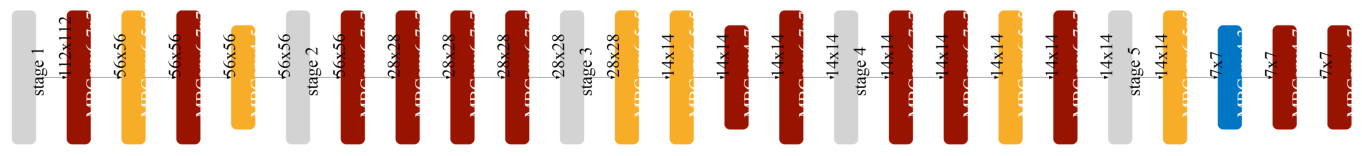

In [5]:
# visualization of network
def visualize_subnet(cfg):
    image_size = 224
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], image_size, out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

visualize_subnet(cfg)

In [6]:
cfg['r']= [224]

acc = accuracy_predictor.predict_accuracy([cfg])
print(acc*100)

tensor([[84.8253]])


Now, we have the powerful **accuracy predictor**. We then introduce two types of **efficiency predictors**: the latency predictor and the FLOPs predictor. 

The intuition of having efficiency predictors, especially the latency predictor, is that measuring the latency of a sub-network on-the-fly is also costly, especially for FPGA devices becuase it takes hours of work to implement even a single network and then measure latency.

The latency predictor is designed to eliminate this cost.

## 5. Defining Efficient Arthemetic intensity Constraint

Trying to do three things maximizing the mac operations perfomed by model which represents the learning capacity
of model while minimizing the number of paramters which is the size of model and also minimizing the latency 
on target hardware thus finding a model that has performs maximum calculation while being smaller and faster



In [7]:
class EfficientCapacityEstimator:
    
    def __init__(self, arthemetic_intensity_lookup, latency_estimator):
        self.ai = arthemetic_intensity_lookup
        self.lat = latency_estimator
        
     # Both latency estmiator and arthemetic intensity calculator are already defined, we will utilize   
    def predict_efficiency(self, sample):
        arth_int = 1/self.ai.predict_efficiency(sample)  #actualy returns 1/arth_intensity
        latency = self.lat.predict_efficiency(sample)
        
        efficient_arthemetic_intensity = arth_int / latency
        
        # To make the task minimization problem 
        return 1 / efficient_arthemetic_intensity


In [8]:
from fpga_utils.latency_estimation import LatencyTable  

arthemetic_intensity_lookup = ArthIntTable(pred_type='arthemetic_intensity', 
                                  device='cuda:0' if cuda_available else 'cpu',batch_size=1, 
                                  )

latency_estimator = LatencyTable()


efficiency_estimator = EfficientCapacityEstimator(arthemetic_intensity_lookup, latency_estimator)

print('The  Efficient Arthemetic intensity predictor is ready!')

Building the arthemetic_intensity lookup table (resolution=224)...
Built the arthemetic_intensity lookup table (resolution=224)!
The  Efficient Arthemetic intensity predictor is ready!


 lets define a custome configuration of network and then try to estimate it's latency and arthemetic intensity

In [9]:


print(1/arthemetic_intensity_lookup.predict_efficiency(cfg))
print(latency_estimator.predict_efficiency(cfg))
print(efficiency_estimator.predict_efficiency(cfg))


30.673169815330247
37.835
1.2334884274363556


## 6. Run Evolutionary search

Now, let's proceed towards searching for efficient network under latency constraint. We use the same accuracy predictor since accuracy predictors are agnostic to the types of efficiency constraint . For the efficiency predictor, we build a latency table.

Lets try these constraint once

In [10]:
#  Hyper-parameters for the evolutionary search process

P = 1000  # The size of population in each generation
N = 8000  # How many generations of population to be searched
r = 0.3  # The ratio of networks that are used as parents for next generation

params = {
    'constraint_type': 'efficient_arthemetic_intensity', # Efficient Arthemetic intensity constrained search
    'efficiency_constraint': 0.3,  # latency constraint , suggested range [10, 45]
    'mutate_prob': 0.3, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.4, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': efficiency_estimator, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}


finder = EvolutionFinder(**params)

# latency_list = [38, 33, 28, 23, 18, 14, 11]

eai_list = [5]

result_lis = []
result_valids = []
info = []
for efficient_arthemetic_intensity in eai_list:
    st = time.time()
    finder.set_efficiency_constraint(efficient_arthemetic_intensity)
    best_valids, best_info = finder.run_evolution_search()
    ed = time.time()
    
    print('Found best architecture at efficient_arthemetic_intensity <= %.2f ms in %.2f seconds! It achieves %.2f%s predicted accuracy with efficient_arthemetic_intensity of %.2f ms./n' % (efficient_arthemetic_intensity, ed-st, best_info[0] * 100, '%',best_info[-1]))
    result_lis.append(best_info)
    result_valids.append(best_valids)
    info.append(ed-st)

Generate random population...
Start Evolution...


Searching with efficient_arthemetic_intensity constraint (5):   0%|          | 40/8000 [00:18<1:02:23,  2.13it/s]


KeyboardInterrupt: 

The results after runnint them are !

Lets visualize and evalute the found architecutre

In [ ]:
!mkdir Models

## 7. Visualizing and Evaluating Searched Models
Lets build model from config and Replace SE blocks in all these networks

We will be utilizing **[Once-for-All (OFA)](https://github.com/mit-han-lab/once-for-all)** network trained on MobilenetV3 search space as a our supernetwork to intialize the weights which would make the training of our searched network faster.

In [ ]:
net_id  = 'ofa_mbv3_d234_e346_k357_w1.2'
url_base = "https://raw.githubusercontent.com/han-cai/files/master/ofa/ofa_nets/"

ofa_network = OFAMobileNetV3(
            dropout_rate=0,
            width_mult=1.2,
            ks_list=[3, 5, 7],
            expand_ratio_list=[3, 4, 6],
            depth_list=[2, 3, 4],
        )

pt_path = download_url(url_base + net_id, model_dir=".torch/ofa_nets")
init = torch.load(pt_path, map_location="cpu")["state_dict"]
ofa_network.load_state_dict(init)
print('Supernetwork Ready')

In [ ]:
print('Replacing SE blocks of OFA and \n Saving the searched models ')
for arch in result_lis:
    cfg = arch[1]
    visualize_subnet(cfg)  
    ofa_network.set_active_subnet(cfg['ks'], cfg['e'], cfg['d'])
    network = ofa_network.get_active_subnet()
    acc = evaluate_sub(network)
    
    print('The evaluated accuracy is : {}'.format(acc))
    print('--'*50)
    
models = {}   # latency, network pair
for i, arch in enumerate(result_lis):
    cfg = arch[1]
    ofa_network.set_active_subnet(cfg['ks'], cfg['e'], cfg['d'])
    network = ofa_network.get_active_subnet(preserve_weight=True)
    models[new_latency_list[i]] = network

for key, model in models.items():
    replace_all(model)
    name = f"Models/model_search_{key}.pth"
    torch.save(model, name)
    print('Done')

**Saving architecture configuration to a File**

In [ ]:
import json

data = {
    "arch": result_lis,
    "info": info
}

with open('search_data.json', 'w') as file:
    json.dump(data, file)
    
print('The cofig data is exported, \n The exported Data is:')
print(data)

## 8. Retrain the Searched network
Lets fine tune the network on a subset of training set of imagenet.

I previously performed FPGA aware Neural architecutral search and found different models with different latency through evolutionary algorithm.

The obtained network from search process will be now retrained to improve accuracy. Also these models wt were intialized with the help of OFA!

In [ ]:
import torch 
import torchvision
import os
import torch.nn as nn
from torchvision import transforms, datasets
import math
import time
from tqdm import tqdm
import shutil
import matplotlib.pyplot as plt

In [ ]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    print('Using GPU.')
else:
    print('Using CPU.')

In [ ]:
batch_size=32

#I will use a susbset of imagenetval of 10k images 
if cuda_available:
    # path to the ImageNet dataset
    # link --> https://www.kaggle.com/datasets/titericz/imagenet1k-val
    
    imagenet_data_path = '/kaggle/input/imagenet1k-subset-100k-train-and-10k-val/imagenet_subval'

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')
    
    
  
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])
    
    val_data = datasets.ImageFolder(
            root=os.path.join(imagenet_data_path),
            transform=build_val_transform(224)
        )
    

    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=batch_size,  
        shuffle = True,
        num_workers=4,  
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready. Size : {}'.format(len(val_loader)*batch_size))
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

In [ ]:

train_path = '/kaggle/input/imagenet1k-subset-100k-train-and-10k-val/imagenet_subtrain'

train_data = datasets.ImageFolder(
            root= train_path,
            transform=build_val_transform(224)
        )

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size, 
        shuffle = True,
        num_workers=4,  
        pin_memory=True,
        drop_last=False,
    )

print('The ImageNet train set is ready. Size : {}'.format(len(train_loader)*batch_size))

In [ ]:
dataloaders = {}
dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

dataset_sizes = {'train': len(train_loader)*32,
                'val': len(val_loader)*32}
print(dataset_sizes)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    #storing epoch data
    epoch_data = {
        'epoch': [],
        'train': {'loss': [], 'top1_acc': [], 'top5_acc': []},
        'val': {'loss': [], 'top1_acc': [], 'top5_acc': []}
    }
    
    # Create a temporary directory
    tempdir = '/kaggle/working/temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        epoch_data['epoch'].append(epoch+1)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            top1_corrects = 0
            top5_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                
                # Calculate top-1 accuracy
                top1_corrects += torch.sum(preds == labels.data)
                
                # Calculate top-5 accuracy
                _, top5_preds = torch.topk(outputs, 5, dim=1)
                top5_corrects += torch.sum(top5_preds == labels.view(-1, 1))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_top1_acc = top1_corrects.double() / dataset_sizes[phase]
            epoch_top5_acc = top5_corrects.double() / dataset_sizes[phase]
            
            epoch_data[phase]['loss'].append(epoch_loss)
            epoch_data[phase]['top1_acc'].append(epoch_top1_acc)
            epoch_data[phase]['top5_acc'].append(epoch_top5_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Top-1 Acc: {epoch_top1_acc:.4f} Top-5 Acc: {epoch_top5_acc:.4f}')

            if phase == 'val' and epoch_top1_acc > best_acc:
                best_acc = epoch_top1_acc
                best_top5 = epoch_top5_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Top-1 Acc {best_acc:4f} /n Best val Top-5: {best_top5:4f}')

    model.load_state_dict(torch.load(best_model_params_path))

    # Clean up the temporary directory
    shutil.rmtree(tempdir)

    return model, epoch_data


In [ ]:
torch.cuda.empty_cache()
model = torch.load('Models/model_search_11.pth')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.5)

model, epoch_data = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=2)

torch.save(model, 'retrained_model_search_11.pth')
print('*****************************************************')
print(epoch_data)

#### It is clear that accuracy is recoverable and we can obtain comparable accuracy with our efficiency contraints by retraining for few epochs

## 6. Insights and Comparision

In [ ]:
# 'ResNet-152':81.3,
#  'Efficientnet V2 Small': 83.6,

In [ ]:
# import shutil

# def zip_folder(folder_path, zip_path):
#     try:
#         # Zip the entire folder and its contents
#         shutil.make_archive(zip_path, 'zip', folder_path)
#         print(f'Folder "{folder_path}" successfully zipped to "{zip_path}.zip"')
#     except Exception as e:
#         print(f'Error zipping folder: {e}')

# # Example usage:

# zip_folder('/kaggle/working/Models/', '/kaggle/working/models')

In [ ]:
# archs = [
# ['Efficientnet B0', 77.8, 19.5],
# ['Mobilenet V3_large', 77, 11.5],
# ['nvidia_efficientnet_b4',82, 20.3]
# ]


# y = [res[0]*100 for res in result_lis]+ [79.5] #added evaulated accuracy after one epcoh train
# x = [1/res[2] for res in result_lis]+ [20.1]
# plt.figure(figsize=(12, 8))
# plt.xlabel('Arithmetic Intensity (ops/byte)', fontsize=14)
# plt.ylabel('Predicted Accuracy', fontsize=14)

# # Plot the line and scatter plot with 'X' marker for each point in the same color
# plt.plot(x, y, marker='X', linestyle='-', color='blue', markersize=8, label = 'Ours')
# plt.plot(archs[0][2], archs[0][1], marker='*', color='red', label ='other', markersize=10 )
# plt.plot(archs[1][2],archs[1][1], marker = '*', color = 'red', markersize = 10)
# plt.plot(archs[2][2],archs[2][1], marker = '*', color = 'red', markersize = 10)


# # Annotate the middle point
# plt.text(20.2,79, f' Evaluated Accuracy \n after 1 epoch', fontsize = 10)
# plt.text(17, 85.2, f'      FPGA specialized networks', fontsize=12, verticalalignment='bottom', horizontalalignment='left', color='blue')
# plt.text(archs[0][2], archs[0][1], f'  Efficientnet_b0', fontsize=12 )
# plt.text(archs[1][2],archs[1][1], f' {archs[1][0]}')
# plt.text(archs[2][2]+0.1,archs[2][1], f' {archs[2][0]}', fontsize=12)

# plt.ylim(75, 89)
# plt.xlim(10, 24)
# # Add legend
# plt.legend(fontsize=12)
# plt.title('Searching for FPGAs')
# # Show the plot
# plt.show()